Importing Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [10]:
def week_year_to_date(year, week):
    starting_date = datetime(int(year), 1, 1)
    return starting_date + timedelta(int(week)*7-7)


df = pd.read_csv('train.csv')
df['date'] =  df.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

print(df.columns)


Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [ ]:
features = [75]
features.extend(list(range(0, 74)))
df_1 = df.iloc[:, features]
corr_matrix = df_1.corr()
sn.heatmap(corr_matrix, annot=False)
plt.show()

In [ ]:
df_2 = (df
        .corr()
        .loc[:, 'emission']
        .sort_values())
print(df_2)

In [37]:
df.longitude.drop_duplicates()

0        29.290
159      29.472
318      29.653
477      30.031
636      29.102
          ...  
78069    30.662
78228    30.347
78387    28.839
78705    29.713
78864    30.301
Name: longitude, Length: 453, dtype: float64

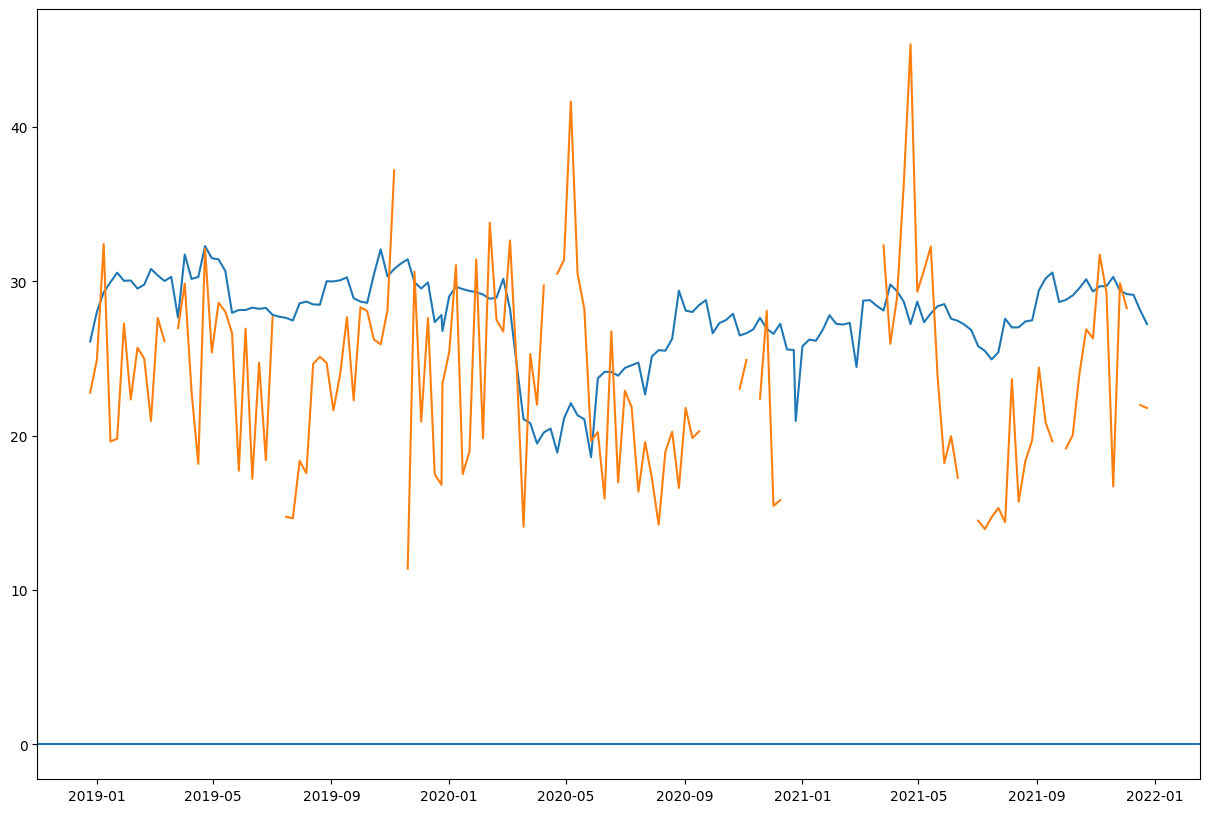

In [42]:
df_3 = (df
        .query("longitude == 30.301"))
plt.figure(figsize=(15, 10))
plt.plot(df_3.date, df_3.emission)
plt.plot(df_3.date, df_3.SulphurDioxide_SO2_column_number_density_amf*25)
plt.axhline()
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['date', 'emission', 'ID_LAT_LON_YEAR_WEEK']), df.emission, test_size = .2)

model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)



Mean Squared Error: 553.4294652939086
SD Error:  23.525081621408003


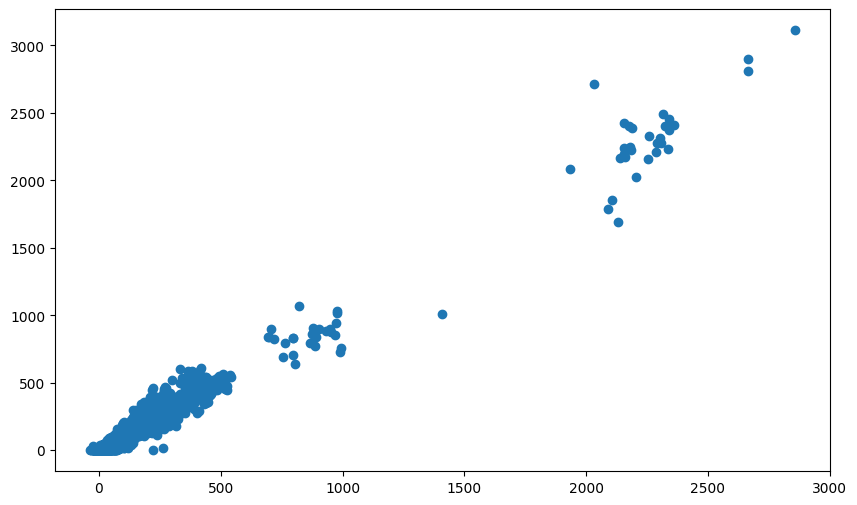

In [49]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', np.sqrt(mse))

plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test)
plt.show()

In [51]:
x_train = df.drop(columns = ['date', 'emission', 'ID_LAT_LON_YEAR_WEEK']).query("longitude != 29.290")
x_test = df.drop(columns = ['date', 'emission', 'ID_LAT_LON_YEAR_WEEK']).query("longitude == 29.290")
y_train = df.query("longitude != 29.290").emission
y_test = df.query("longitude == 29.290").emission
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)


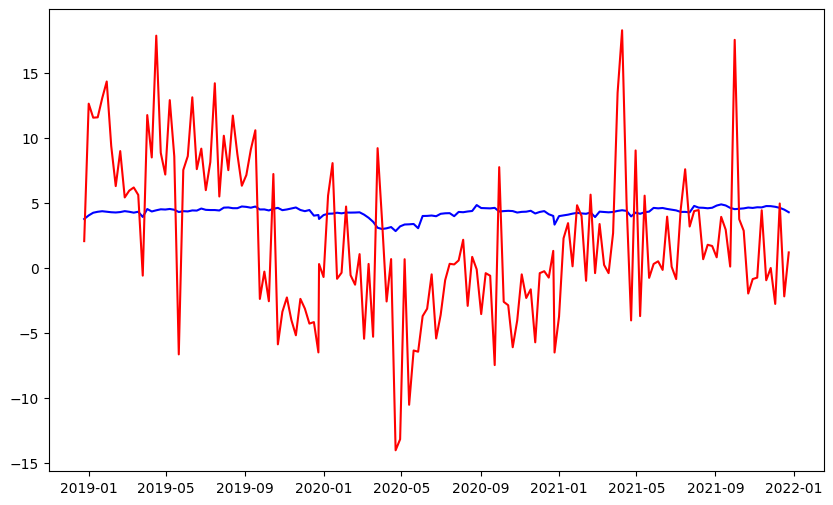

In [52]:
x_test['date'] = x_test.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

plt.figure(figsize = [10, 6])
plt.plot(x_test.date, y_test, color = 'blue')
plt.plot(x_test.date, y_pred, color = 'red')
plt.show()